In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from tqdm import tqdm


if not "root" in locals():
    current_path = Path(os.getcwd())
    root = current_path.parent.absolute()
os.chdir(root)
    
from MyTools.add_AR_cols import add_AR_cols
from data_treatment.box_creator import create_binary_box_end
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from TinyAutoML.Models import *
from TinyAutoML import MetaPipeline

[TinyAutoML] Training models...


              precision    recall  f1-score   support

       False       0.68      0.93      0.79      1083
        True       0.65      0.23      0.34       614

    accuracy                           0.68      1697
   macro avg       0.67      0.58      0.57      1697
weighted avg       0.67      0.68      0.63      1697

None


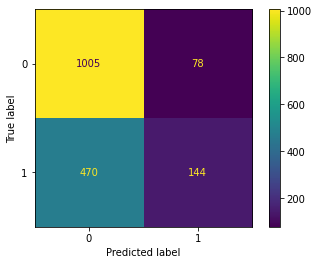

In [71]:
starting_threshold = 2000
box_shift = 3

df = pd.read_csv('database.csv')
df.drop(columns="RF_F-F_Research_Data_5_Factors_2x3_daily", inplace=True) # Y'avait trop de valeurs identiques d'afilée
df = add_AR_cols(df, 10).set_index(['Date'])
df = create_binary_box_end(df, threshold = 0.03, box_shift=box_shift).dropna(axis = 0)
X,y = df.drop('Box', axis=1)[df.index<df.index[starting_threshold]], df['Box'][df.index<df.index[starting_threshold]]
mpipe = MetaPipeline(DemocraticModel(comprehensiveSearch=False, parameterTuning=False, metrics="precision", voting="soft"), )
mpipe.fit(X,y)

X_future,y_future = df.drop('Box', axis=1)[df.index>df.index[starting_threshold]], df['Box'][df.index>df.index[starting_threshold]]
print(mpipe.classification_report(X_future,y_future))
cm = confusion_matrix(y_future, mpipe.predict(X_future))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [113]:
class LongPosition:
    def __init__(self, initial_price, amount, maturity, date):
        self.initial_price = initial_price
        self.amount = amount
        self.maturity = maturity
        self.total_value = amount * self.initial_price
        self.date = date
    def update_maturity(self):
        self.maturity -= 1
    def update_value(self, current_price):
        self.total_value = self.amount * current_price
    def value(self):
        return self.total_value 
    def at_maturity(self):
        return self.maturity <= 0
    
class Portfolio:
    def __init__(self, starting_cash):
        self.positions = []
        self.total_assets_value = 0
        self.cash = starting_cash
        self.positions_history = {"Date": [], "buy_price": [], "sell_price": [], "portfolio_value": [], "amount": []}
        
    def add_long_position(self, initial_price, amount, maturity, date, allow_negative_cash = True, comission = 0):
        if allow_negative_cash or self.cash > initial_price * amount:
            self.positions.append(LongPosition(initial_price, amount, maturity, date))
            self.cash -= (1+comission) * self.positions[-1].value()
            
    def update_values(self, current_price):
        portfolio_total_assets_value = 0
        for position in self.positions:
            position.update_value(current_price)
            portfolio_total_assets_value += position.value()
        self.total_assets_value = portfolio_total_assets_value + self.cash
        
    def value(self, current_price):
        self.update_values(current_price)
        return self.total_assets_value
    
    def update_maturities(self):
        for position in self.positions:
            position.update_maturity()  
            
    def check_maturities_and_sell(self, current_price):
        remaining_positions = []
        for position in self.positions:
            if position.at_maturity():
                self.cash += position.value()
                self.total_assets_value -= position.value()
                self.positions_history["Date"].append(position.date)
                self.positions_history["buy_price"].append(position.initial_price)
                self.positions_history["sell_price"].append(current_price)
                self.positions_history["portfolio_value"].append(self.value(current_price))
                self.positions_history["amount"].append(position.amount)
            else:
                remaining_positions.append(position)
        self.positions = remaining_positions
        
    def update_portfolio(self, current_price):
        self.update_values(current_price)
        self.update_maturities()
        self.check_maturities_and_sell(current_price)

In [114]:
VIX_open = 'PX_OPEN_VIX_volatility'
training_frequency = 500
amount_change_frequency = 10
default_amount = 20
current_amount = default_amount
base_cash = 1000

ptf = Portfolio(base_cash)
for i in (pbar := tqdm(range(starting_threshold, len(df.index)))):
    
    if (i+1) % training_frequency == 0:
        print("Training model...", end = "")
        X,y = df.drop('Box', axis=1)[df.index<df.index[i]], df['Box'][df.index<df.index[i]]
        mpipe = MetaPipeline(DemocraticModel(comprehensiveSearch=False, parameterTuning=False, metrics="precision", voting="soft"), )
        mpipe.fit(X,y)
        print(" Done!")
    
    if (i+1) % amount_change_frequency == 0:
        current_amount = round(default_amount * ptf.total_assets_value / base_cash)
    
    X_today = df.drop('Box', axis=1)[df.index <= df.index[i]]
    price = X_today.iloc[-1][VIX_open]
    result = mpipe.predict(X_today)[-1]
    if result == 1:
        ptf.add_long_position(initial_price = price, amount = current_amount, maturity = box_shift, date = df.index[i], comission=0.05)
    ptf.update_portfolio(price)
    pbar.set_description(f"Value: {str(round(ptf.value(price)))}, amount: {current_amount}")
        
    

Value: 2815, amount: 56:  29%|██▉       | 499/1698 [00:44<01:50, 10.86it/s]

Training model...

Value: 2815, amount: 56:  29%|██▉       | 500/1698 [00:59<52:58,  2.65s/it]

 Done!


Value: 5727, amount: 115:  59%|█████▉    | 999/1698 [01:53<01:14,  9.40it/s]

Training model...

[TinyAutoML] Training models...
Value: 5727, amount: 115:  59%|█████▉    | 1000/1698 [02:13<48:41,  4.19s/it]

 Done!


Value: 10015, amount: 195:  88%|████████▊ | 1499/1698 [03:13<00:22,  8.93it/s]

Training model...

[TinyAutoML] Training models...
Value: 10015, amount: 200:  88%|████████▊ | 1500/1698 [03:37<24:19,  7.37s/it]

 Done!


Value: 11839, amount: 228: 100%|██████████| 1698/1698 [03:59<00:00,  7.08it/s]


In [115]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "browser"

df_positions = pd.DataFrame(ptf.positions_history)
df_positions["buy_price"] = df_positions["buy_price"]
df_positions["Diff"] = df_positions["sell_price"] -df_positions["buy_price"]

#px.scatter(df_positions, x = "Date", y = ["Diff"], marginal_y="histogram")

In [116]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

VIX_df = df[df.index<=df_positions["Date"][df_positions.shape[0]-1]]
VIX_series = VIX_df[VIX_df.index>=df_positions["Date"][0]][VIX_open]

fig = make_subplots(specs=[[{"secondary_y": True}], [{"secondary_y": True}]], rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02)

# Add traces
fig.add_trace(
    go.Scatter(x=VIX_series.index, y=VIX_series.values, name="VIX"),
    secondary_y=False, row = 1, col = 1
)

fig.add_trace(
    go.Scatter(x=df_positions["Date"], y=df_positions["portfolio_value"], name="Portfolio"),
    secondary_y=True, row = 1, col = 1
)

fig.add_trace(
    go.Scatter(x=df_positions["Date"], y=df_positions["Diff"], name="Price delta", mode='markers', 
               marker=dict(
                    size=10,
                    cmax=3,
                    cmin=-3,
                    color=df_positions["Diff"],
                    colorbar=dict(len=0.5, y=0.25),
                    cmid = 0,
                    colorscale="RdYlGn")),
    secondary_y=False, row = 2, col = 1)

fig.add_trace(
    go.Scatter(x=df_positions["Date"], y=df_positions["amount"], name="Amount bought"),
    secondary_y=True, row = 2, col = 1
)

# Add figure title
fig.update_layout(title_text="VIX Trading algorithm")

# Set x-axis title
fig.update_xaxes(title_text="Date", row = 2, col = 1)

# Set y-axes titles
fig.update_yaxes(title_text="<b>VIX</b> value", secondary_y=False, row = 1, col = 1)
fig.update_yaxes(title_text="<b>Portfolio</b> value", secondary_y=True, row = 1, col = 1)
fig.update_yaxes(title_text="<b>Price delta</b>", secondary_y=False, row = 2, col = 1)
fig.update_yaxes(title_text="<b>Amount bought</b>", secondary_y=True, row = 2, col = 1)

fig.show()

In [101]:
VIX_open = 'PX_OPEN_VIX_volatility'
training_frequency = 500
amount_change_frequency = 10
default_amount = 20
current_amount = default_amount
base_cash = 1000

ptf = Portfolio(base_cash)
for i in (pbar := tqdm(range(starting_threshold, len(df.index)))):
    
    
    if (i+1) % amount_change_frequency == 0:
        current_amount = round(default_amount * ptf.total_assets_value / base_cash)
    
    X_today = df.drop('Box', axis=1)[df.index <= df.index[i]]
    price = X_today.iloc[-1][VIX_open]
    
    if np.random.random() > 0.9:
        ptf.add_long_position(initial_price = price, amount = current_amount, maturity = box_shift, date = df.index[i])
    ptf.update_portfolio(price)
    pbar.set_description(f"Value: {str(round(ptf.value(price)))}, amount: {current_amount}")

Value: 627, amount: 12: 100%|██████████| 1698/1698 [00:03<00:00, 526.01it/s] 


,PX_OPEN_VIX_volatility,Box
Date,,
2006-02-28,11.74,False
2006-03-01,12.05,False
2006-03-02,11.79,True
2006-03-03,12.03,True
2006-03-06,12.22,False
...,...,...
2021-05-18,18.89,True
2021-05-19,22.46,False
2021-05-20,22.33,False


In [123]:
mpipe.score(X_future, y_future)

0.7065409546258102